this notebooks was based on the SubCell_Tutorial_SARS_CoV_2_data available at: https://virtualcellmodels.cziscience.com/tutorial/subcell-tutorial


## Introduction to SubCell
SubCell is a suite of image encoder models developed by Ankit Gupta in Professor Emma Lundberg’s lab. The SubCellPortable Github repository provides code to run the suite of models along with classifier models that were trained on the SubCell embeddings to classify which of 31 different localization categories, such as nucleoli, vesicles, or mitochondria, correspond to a given protein of interest.

Each image encoder model takes as inputs fluorescence microscopy images of cells stained for a protein of interest along with reference markers (nuclei, microtubules, and endoplasmic reticulum) and outputs image embeddings. SubCell models were trained with different combinations of reference markers and each model therefore expects different input channels to run inference. These are summarized in the table below along with the abbreviations used for each model in `SubCellPortable`. For each set of reference markers, 2 encoder models are available: the "ViT" version was trained with only protein-specific loss, and the "MAE" version was trained with Masked Autoencoder (MAE) Reconstruction Loss, cell-specific and protein-specific losses.

| SubCell Model       | SubCellPortable Name | Reference Images Required          |
|----------------------|----------------------|-------------------------------------|
| DNA-protein         | bg                   | nuclei                              |
| MT-DNA-protein      | rbg                  | microtubules and nuclei            |
| all-channels        | rybg                 | microtubules, ER, and nuclei       |
| ER-DNA-Protein      | ybg                  | ER and nuclei                      |

SubCell was trained on individual cell crops from the Human Protein Atlas (HPA) SubCellular data, which includes immunofluorescence of 13,147 proteins of interest and 37 different human cell lines. Below are example field of view images for each of the 4 channels in the 2D HPA data: endoplasmic reticulum (yellow), nucleus (blue), microtubules (red), and protein of interest (green).

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import argparse
import datetime
import logging
import os
import sys
import pandas as pd
import requests
import torch
import yaml
from skimage.io import imread
import boto3
from botocore import UNSIGNED
from botocore.config import Config
from botocore.exceptions import ClientError
from urllib.parse import urlparse

import subcellportable.inference
from subcellportable.vit_model import ViTPoolClassifier

In [4]:
os.environ["DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
# This is the log configuration. It will log everything to a file AND the console
logging.basicConfig(
    filename="log.txt",
    encoding="utf-8",
    format="%(levelname)s: %(message)s",
    filemode="w",
    level=logging.INFO,
)
console = logging.StreamHandler()
logging.getLogger().addHandler(console)
logger = logging.getLogger("SubCell inference")

# This is the general configuration variable. We are going to use the special key "log" in the dictionary to use the log in our code
config = {"log": logger}

# If you want to use constants with your script, add them here
config["model_channels"] = "rybg"

# mapping between subcell and clockbio data
channels_dict = {
    "b": "1",
    "g": "2",
    "r": "4",
    "y": "6"
}
config["model_type"] = "vit_supcon_model"  # "mae_contrast_supcon_model"
config["update_model"] = True
config["create_csv"] = True
config["gpu"] = 0

# Log the start time and the final configuration so you can keep track of what you did
config["log"].info("Start: " + datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"))
config["log"].info("Parameters used:")
config["log"].info(config)
config["log"].info("----------")

Start: 2025/04/24 15:50:45
Parameters used:
{'log': <Logger SubCell inference (INFO)>, 'model_channels': 'rybg', 'model_type': 'vit_supcon_model', 'update_model': True, 'create_csv': True, 'gpu': 0}
----------


In [6]:
from subcellportable.load import model_load

In [7]:
model = model_load(config)

- Downloading models...


/home/sagemaker-user/Image-engine/SubCellPortable/src/models/rybg/vit_supcon_model/classifier_s0.pth 
 models/all_channels_ViT_MLP_classifier/all_channels_ViT_MLP_classifier_seed_0.pth


  - /home/sagemaker-user/Image-engine/SubCellPortable/src/models/rybg/vit_supcon_model/classifier_s0.pth updated.
  - /home/sagemaker-user/Image-engine/SubCellPortable/src/models/rybg/vit_supcon_model/encoder.pth updated.


Encoder status: <All keys matched successfully>
Pool model status: <All keys matched successfully>
Classifier 1 status: <All keys matched successfully>


In [8]:
# if we want to generate a csv result
if config["create_csv"]:
    final_columns = [
        "id"
    ]
    if classifier_paths:
        final_columns.extend([
            "top_class_name",
            "top_class",
            "top_3_classes_names",
            "top_3_classes",
        ])
        prob_columns = []
        for i in range(31):
            prob_columns.append("prob" + "%02d" % (i,))
        final_columns.extend(prob_columns)
        feat_columns = []
    for i in range(1536):
        feat_columns.append("feat" + "%04d" % (i,))
    final_columns.extend(feat_columns)
    df = pd.DataFrame(columns=final_columns)

NameError: name 'classifier_paths' is not defined

https://colab.research.google.com/drive/1-lliCeBdaXAhsrphZEy8VerFOrgO-Lw1#scrollTo=QNR0x8X0dFFM
https://virtualcellmodels.cziscience.com/tutorial/subcell-tutorial
https://virtualcellmodels.cziscience.com/model/0193323e-ebd5-727c-bb32-87ed8f737213?utm_source=czi&utm_campaign=MVP_launch&utm_medium=blog

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import numpy as np
import fsspec
import re
import io
from tqdm.auto import tqdm
import s3fs
from cell_engine.data import filepaths_retrieval

fs = s3fs.S3FileSystem()

csv_path = "s3://clockbio.loka/All_cell_coordinates_15lines.csv"
imgs_path = "s3://clockbio.loka/Images_Data/*.tif"

meta_df = pd.read_csv(csv_path)
paths_df = filepaths_retrieval(imgs_path)

In [11]:
paths_df["id"].unique().shape

(306970,)

In [7]:
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray

def open_image_skimage(path, target_shape=None):
    with fsspec.open(path, 'rb') as f:
        img = imread(io.BytesIO(f.read()))
    if target_shape:
        img = resize(img, target_shape, preserve_range=True, anti_aliasing=True)
    img = rgb2gray(img) if img.ndim == 3 else img

    return img.astype(img.dtype)

# NOTE: usually pil is faster, but for this use case it seems the same
def open_image_pil(path, target_shape=None, as_array=False):
    with fsspec.open(path, 'rb') as f:
        img = Image.open(io.BytesIO(f.read())).convert("L")
        if target_shape is not None:
            img = img.resize(target_shape, Image.BILINEAR)  # or Image.LANCZOS

        if as_array:
            img = np.array(img)

        return img

def load_multichannel_image(path: str, channel_nums: list) -> np.ndarray:
    """
    Loads and stacks images where the only difference is the _C#_ channel pattern.
    """
    def replace_channel(path, i):
        return re.sub(r"_C\d+_", f"_C{i}_", path)

    images = [
        np.array(open_image_skimage(replace_channel(path, i)))
        for i in channel_nums
    ]
    return np.stack(images, axis=-1)

In [8]:
img_path = paths_df["filepath"].values[0]

In [9]:
open_image_pil(img_path,
               as_array=True,
            #    target_shape=(640, 640)
               ).shape

(454, 358)

In [10]:
open_image_skimage(img_path,
                #    target_shape=(640, 640)
                   ).shape

(454, 358)

In [11]:
channel_filt = [v for k, v in channels_dict.items() if k in config["model_channels"]]
output_folder = f"../artifacts/subcell_estimates/{config['model_channels']}-{config['model_type']}"
target_shape = (640, 640)

# filtering only the channels used
paths_df = paths_df[paths_df["channel"].isin(channel_filt)]
sample_num = 2000

sampled_ids = pd.Series(paths_df["id"].unique()).sample(sample_num, random_state=42)
filt_df = paths_df[paths_df['id'].isin(sampled_ids)]

In [12]:
from tqdm.auto import tqdm
import time

In [17]:
# Create the output folder
os.makedirs(output_folder, exist_ok=True)
total_tqdm = filt_df["id"].unique().shape[0]
times_df = []
df = df[:0]
# df = df.drop(columns=["channel", "age", "treatment"])
for img_id, g_df in tqdm(filt_df.groupby("id"), total=total_tqdm):
    img_embds_path = os.path.join(output_folder, "embds")
    os.makedirs(img_embds_path, exist_ok=True)

    channels_load_start = time.time()
    # We load the images as numpy arrays
    cell_data = []
    if "r" in config["model_channels"]:
        img_path = g_df[g_df["channel"] == channels_dict["r"]]["filepath"].values[0]
        cell_data.append([open_image_skimage(img_path, target_shape=target_shape)])
    if "y" in config["model_channels"]:
        img_path = g_df[g_df["channel"] == channels_dict["y"]]["filepath"].values[0]
        cell_data.append([open_image_skimage(img_path, target_shape=target_shape)])
    if "b" in config["model_channels"]:
        img_path = g_df[g_df["channel"] == channels_dict["b"]]["filepath"].values[0]
        cell_data.append([open_image_skimage(img_path, target_shape=target_shape)])
    if "g" in config["model_channels"]:
        img_path = g_df[g_df["channel"] == channels_dict["g"]]["filepath"].values[0]
        cell_data.append([open_image_skimage(img_path, target_shape=target_shape)])

    all_channels_load = time.time() - channels_load_start

    infer_start = time.time()
    # We run the model in inference
    embedding, probabilities = inference.run_model(
        model,
        cell_data,
        device,
        os.path.join(img_embds_path, img_id),
    )
    infer_time = time.time() - infer_start

    classifier_start = time.time()
    if classifier_paths:
        curr_probs_l = probabilities.tolist()
        max_location_class = curr_probs_l.index(max(curr_probs_l))
        max_location_name = inference.CLASS2NAME[max_location_class]
        max_3_location_classes = sorted(
            range(len(curr_probs_l)), key=lambda sub: curr_probs_l[sub]
        )[-3:]
        max_3_location_classes.reverse()
        max_3_location_names = (
            inference.CLASS2NAME[max_3_location_classes[0]]
            + ","
            + inference.CLASS2NAME[max_3_location_classes[1]]
            + ","
            + inference.CLASS2NAME[max_3_location_classes[2]]
        )

    # Save results in csv format
    if config["create_csv"]:
        new_row = []
        new_row.append(img_id)
        if classifier_paths:
            new_row.append(max_location_name)
            new_row.append(max_location_class)
            new_row.append(max_3_location_names)
            new_row.append(",".join(map(str, max_3_location_classes)))
            new_row.extend(probabilities)
        new_row.extend(embedding)
        df.loc[len(df.index)] = new_row

        log_message = "- Saved results for " + img_id

        if classifier_paths:
            log_message = log_message + ", locations predicted [" + max_3_location_names + "]"
        # config["log"].info(log_message)
    times_df.append({
        "all_channels_load": all_channels_load,
        "infer_time": infer_time,
        "classifier_and_io": time.time() - classifier_start
    })


if config["create_csv"]:
    df.to_csv(os.path.join(output_folder, "result.csv"), index=False)
    pd.DataFrame(times_df).to_csv(os.path.join(output_folder, "times_df.csv"))
config["log"].info("----------")
config["log"].info("End: " + datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

  0%|          | 0/2000 [00:00<?, ?it/s]

----------
End: 2025/04/21 18:25:31


In [19]:
pd.DataFrame(times_df).agg(['mean', 'std', 'median'])

,all_channels_load,infer_time,classifier_and_io
mean,1.006290,0.165480,0.097556
std,0.135807,0.007505,0.289417
median,1.044317,0.165801,0.047723


In [13]:
# Import libraries that come pre-installed in Google Colab
import pandas as pd # data analysis library
import matplotlib.pyplot as plt # visualization library
import seaborn as sns # visualization library

# Import umap-learn library that was installed in the above cell
import umap # dimensionality reduction library

In [37]:
# read result.csv into a pandas dataframe
out_fold = f"../artifacts/subcell_estimates/{config['model_channels']}-{config['model_type']}"
df = pd.read_csv(f"{out_fold}/result.csv")

# define 'ids' as the id column from `result.csv` (output prefix for a cell)
ids = df["id"]
df = pd.merge(
    df,
    paths_df[["id", "age", "treatment", "plate"]].drop_duplicates(),
    on="id",
    how="inner"
)

df = df[(df["treatment"] != "UNS")]

In [91]:
# extract the embedding vectors (all columns that start with 'feat')
features = df.loc[:, df.columns.str.startswith("feat")]

# apply UMAP to the embedding vectors
n_components = 4
umap_model = umap.UMAP(n_components=n_components, n_neighbors=100, min_dist=0.6,
                     metric="cosine", random_state=42)
reduced_features = umap_model.fit_transform(features)

# Create a dataframe for the reduced embeddings along with their annotations
umap_df = pd.DataFrame(reduced_features, columns=[f"UMAP{i}" for i in range(1, n_components + 1)])
umap_df["age"] = df["age"]
umap_df["treatment"] = df["treatment"]
umap_df["plate"] = df["plate"]
umap_df["age"] = umap_df["age"].astype("float")

/home/sagemaker-user/Image-engine/artifacts/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/sagemaker-user/Image-engine/artifacts/env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


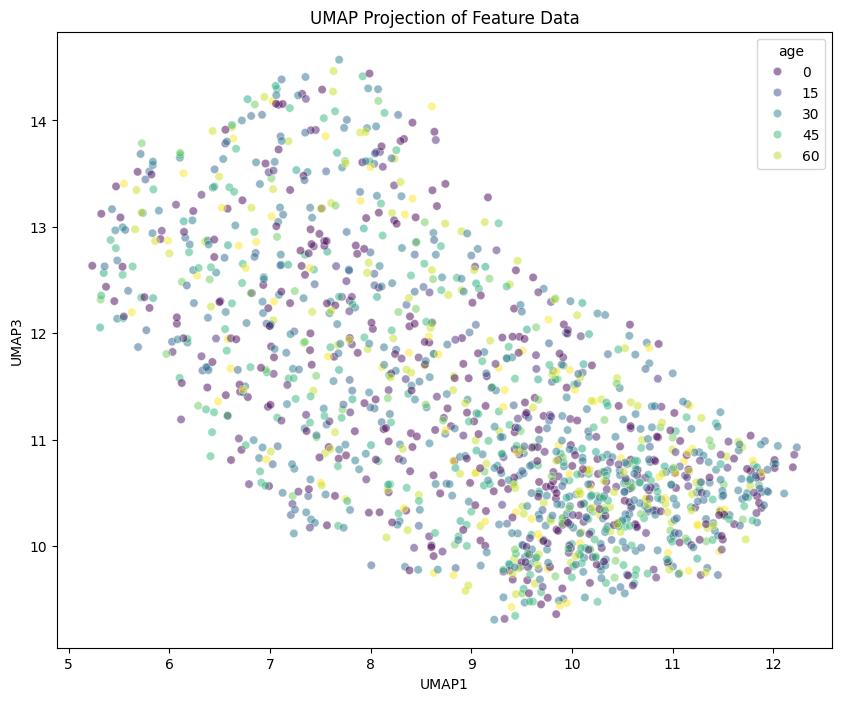

In [94]:
# Use matplotlib and seaborn to visualize the results as a UMAP
fig = plt.figure(figsize=(10, 8))
palette = "viridis"  # viridis
hue = "age"
sns.scatterplot(
    data=umap_df,
    x="UMAP1",
    y="UMAP3",
    hue=hue,
    # style="treatment",
    palette=palette,  # "tab10",  # Set palette for unique colors per dataset
    markers=["o", "P"],  # Shapes for infected and uninfected
    alpha=0.5
)

# Add legend and title
# plt.legend(title="Gene and Infection Status")
plt.title("UMAP Projection of Feature Data")
plt.show()

# fig.savefig(os.path.join(out_fold, f"umap_exp_{hue}_{palette}.png"))